# CNN for word reconition using IAM dataset
# 使用IAM数据集训练卷积神经元网络识别手写英文单词


```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

### 环境和数据要求

IAM 的word数据集和word.txt需要提前下载解压
IAM 的word数据我们进行了清洗和预处理，只选出了满足一下条件的单词图片用于训练，

    标注正确的图片，IAM 说明文件word.txt里注明了哪些图片的标注是正确的
    标注为英语单词的图片
    符合以上两个条件的图片数量大于50张的单词
    对每个单词，随机选取10%的图片用于测试，其他90%用于训练
    对于入选的单词图片，确定统一的图片分辨率（100，300）
    把图片转换为黑底白字234x675的图片
清洗后一共39618张训练图片，4487张测试图片，只有166个不同的单词，每个单词的图片数量都不一样，有的多，有的少

同样待识别的图片必须是黑底白字234x675的图片

依赖的Python包:
    tensorflow==1.3 
    pillow 
    matplotlib
    opencv
    numpy
    matplotlib

### Overview

此程序使用Tensorflow的Estimator API 和 Dataset API，这两个新的API可以简化模型的创建

Estimator API 入门指南
https://www.tensorflow.org/get_started/custom_estimators

Dataset API 入门指南
https://www.tensorflow.org/get_started/datasets_quickstart


### 导入需要的包

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
from random import shuffle
import os
import glob
# Image processing
from PIL import Image

# We use matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import csv
#from PreProcessImage import cropImg
#from PreProcessImage import blackwhiteImg
import math

### 设置环境参数和超级参数

In [66]:
# 工作目录
WORK_DIR = os.path.curdir
# 存放经过预处理过的训练数据和测试数据的目录
TRAIN_DIR = 'C:/Data/AI/IAM/small_img_size/trainImg'
TEST_DIR = 'C:/Data/AI/IAM/small_img_size/testImg'
# 结果和日志存放目录
LOG_DIR = WORK_DIR + '/iam_output_smallsize'

# 训练的次数
TRAINING_STEPS = 20000
# 每次并行训练的样本数量，即批次大小
BATCH_SIZE = 64
# 每隔几次输出存储训练结果到日志文件
PRINT_STEPS = TRAINING_STEPS / 100

# 学习率,设为0.01（1e-2)
# 如果太大，训练结果不稳定
# 如果太小，训练过慢，难以收敛
LEARNING_RATE = 1e-2
# Momentum smoothes out sudden changes in the gradient
# 动量能够平滑下降突变
MOMENTUM = 0.1
# 输入图片的分辨率
IMAGE_RES = [100,300]

# 每隔多少次训练，用测试数据评估模型识别准确率
VALIDATE_EVERY = 2000

# 自定义参数词典，大多数是模型需要的超级参数
params = { 'log_dir' : LOG_DIR,
           'learning_rate' : LEARNING_RATE,
           'momentum': MOMENTUM,
           'base_channels': 8,
           'weight_decay': 1e-5,
           'print_steps' : PRINT_STEPS,
           'save_summary_steps' : PRINT_STEPS,
           'save_checkpoint_steps' : VALIDATE_EVERY,
           'validate_every' : VALIDATE_EVERY,
           'train_steps' : TRAINING_STEPS,
           'num_classes' : 166,
           'threshold_probability': 0.4
           }

### 准备数据集


### 看一下数据集
在下面的代码块里按 (Control + Enter) 查看多个IAM的手写单词图片


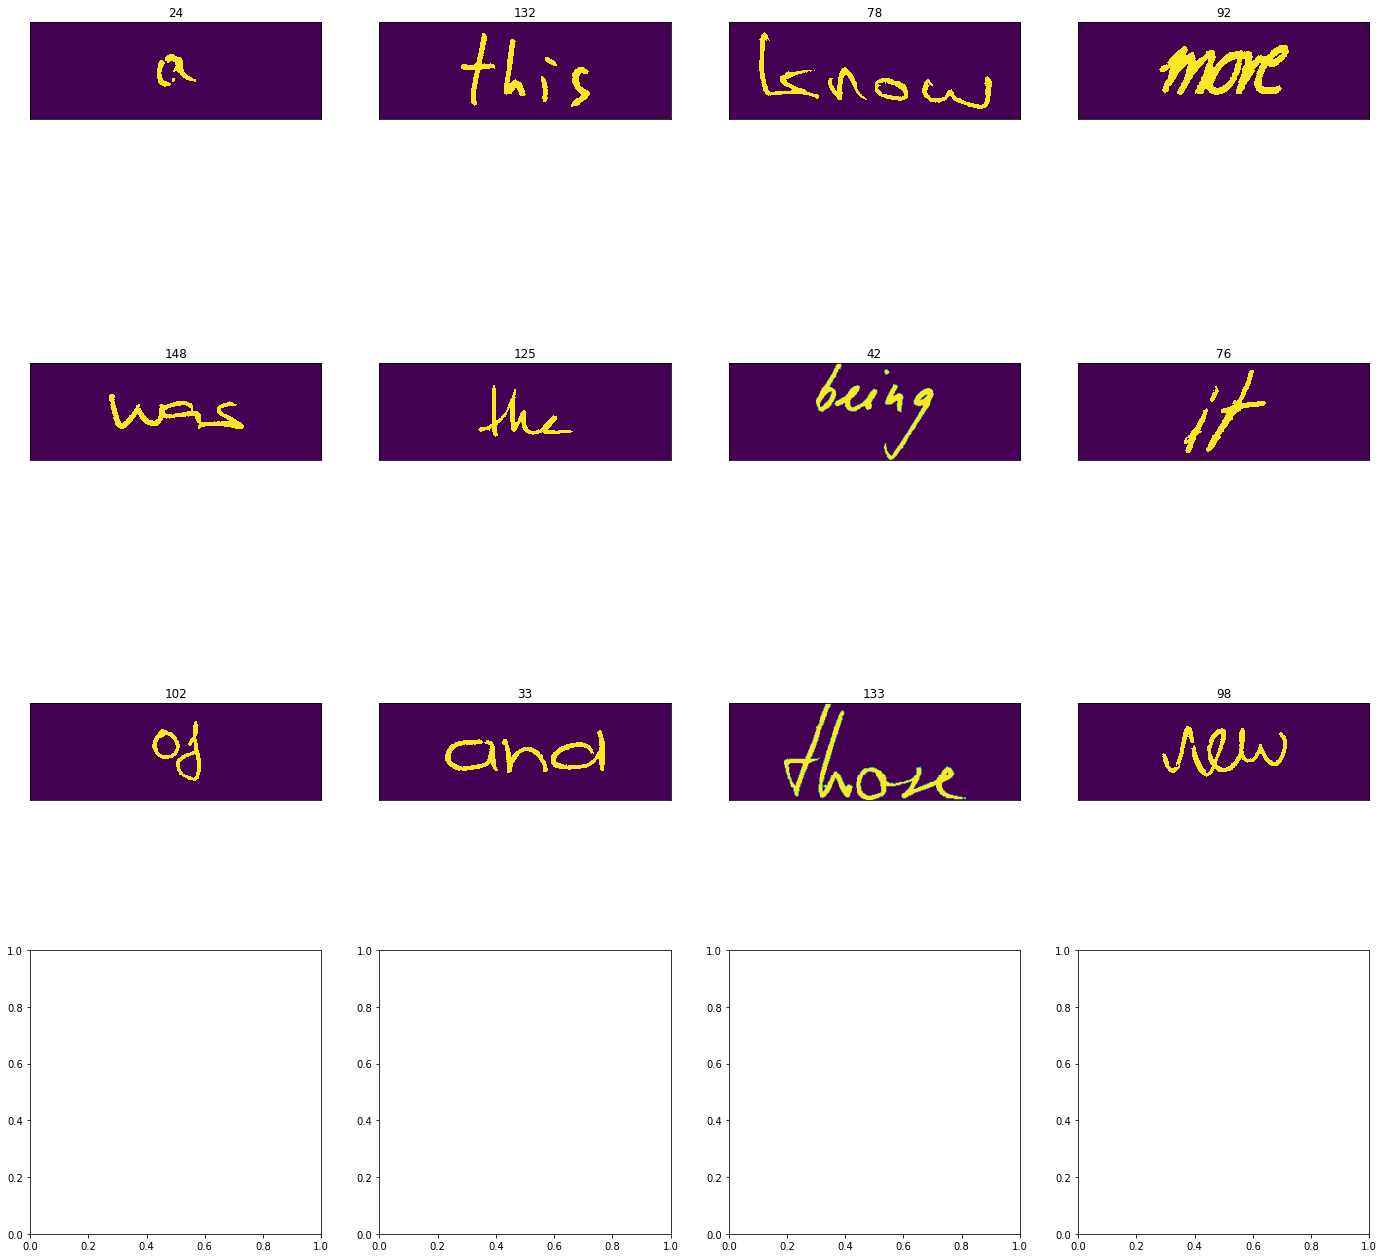

In [3]:
num_images = 12

assert num_images % 4 == 0, "Please choose a number of images that divides by 4."

files = sorted(glob.glob(TRAIN_DIR+'/*/*.png'))

shuffle(files)
files = files[:num_images]
labels = [filename.split(os.sep)[-2] for filename in files]
# 显示4列图片，图片大小为（12，6）
fig, axs = plt.subplots((num_images // 4+1), 4, figsize=(24,24))
axs = axs.ravel()
count = 0
for file, label in zip(files, labels):
    
    img=mpimg.imread(file)
    axs[count].set_title(label)
    axs[count].imshow(img)
    axs[count].set_xticks([])
    axs[count].set_yticks([])
    count += 1 


### Image and label retrieval helper functions

In [4]:
# 返回目录里的图片文件全路径集
def get_sample_filenames(directory, level=1):
    if level==1:
        file_set = sorted(glob.glob(directory+'/*/*.png'))
        
    else:
        file_set = sorted(glob.glob(directory+'/*.png'))
        if len(file_set) == 0:
            file_set=sorted(glob.glob(directory+'/*.jpg'))

        #file_set = sorted(file_set)

    # We need to shuffle so that all classes are (equally) represented
   # shuffle(files)

    #num_train_samples = int(len(files) * train_fraction)

    #train_set = files[:num_train_samples]
    #valid_set = files[num_train_samples:]

    return file_set




# 从文件名中提取标注，比如子文件名a01-026u-07-02-But-4.png, 对应标注就是4，类别4对应单词but
def get_labels(filenames):

    #return np.asarray([np.int32(filename.split(os.sep)[-2]) for filename in filenames])
    return np.asarray([np.int32(filename.split(os.sep)[-1].split('.')[-2].split('-')[-1]) for filename in filenames])



# 返回文件对应的图片，并且把图片调整为目标分辨率
def load_sample(filename,target_res):
    #print(filename)
    # Load image data
    #print("load sample:", filename)
    image_data = tf.read_file(filename)
    #print(image_data)
    # convert data into gray image
    image_decoded = tf.image.decode_png(image_data,channels=1)

    # resize image
    image_decoded = tf.image.resize_images(image_decoded, target_res, method=tf.image.ResizeMethod.BILINEAR)
    # make sure type is uint8 (note that this part of the graph is still on CPU/RAM)
    # If we convert to float32 here, we would need to transfer more data to GPU which is slower!
    # image_decoded是一个图片张量tensor
    image_decoded = tf.cast(image_decoded, tf.uint8)
    
    return image_decoded

In [5]:
sample_set = get_sample_filenames(TRAIN_DIR,1)
#print(sample_set)
for file in sample_set:
    if (os.path.getsize(file)==0):
    
        print(file)

(100, 300, 1) Label: 100


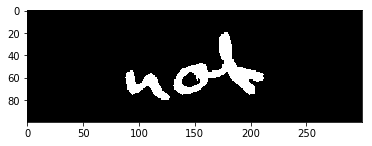

In [7]:
# 该段代码不需要执行，只是为了展示dataset API的使用，还有如何显示tensor里的灰度图片
filename_list = get_sample_filenames(TRAIN_DIR,1)
label_list = get_labels(filename_list)
#for i in range(135):
    #print(label_list[i])
filenames = tf.constant(filename_list)   

# label[i]就是图片filenames[i]的label
labels = tf.constant(label_list)

# 此时dataset中的一个元素是(filename, label)
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# 对dataset中的每个元素(filename, label)运行load_sample函数，返回包含(image_decoded，label)的dataset
dataset = dataset.map(lambda filename, label : (load_sample(filename, target_res=IMAGE_RES), label))

# 此时dataset中的每个元素是(image_decoded, label)
# 让dataset可以无限重复取值
#dataset = dataset.repeat()
# 得到遍历每个dataset元素的iterator
iterator = dataset.make_one_shot_iterator()
# 取dataset的一个元素，这里 image和label都是一个tensor
nextElement = iterator.get_next()
              
with tf.Session() as sess:
    for i in range(132): 
        image, label = sess.run(nextElement)
        #print(image.shape, "Label:", label)
        if i==131:
            print(image.shape, "Label:", label)
            image = np.reshape(image,IMAGE_RES)
            plt.imshow(image,cmap='gray')
        #image = np.reshape(image.eval(),(234,675))
        #plt.imshow(image,cmap='gray')



### Some Tensorflow helper classes and functions

In [8]:
# 自定义的Output_hook, 后面会加到training_hooks里，用于每次训练时回调运行，把结果写到LOG_DIR/training.txt 文件
class OutputHook(tf.train.SessionRunHook):

    def __init__(self, name, log_dir=None, logged_tensors={}, save_steps=100):

        self._logdir = log_dir
        self._logged_tensors = logged_tensors
        self._save_steps = save_steps
        self._name = name

    def begin(self):
        # 我们需要知道当前在哪一次训练里，这可以从'global_step' tensor中得到
        self._global_step_tensor = tf.train.get_global_step()
        self._logged_tensors['step'] = self._global_step_tensor

    def before_run(self, run_context):
        """ This routine is executed by Tensorflow before each training step.
            It returns a dictionary of tensors that shall be
            evaluated by the actual training step (i.e. the implicit session.run call).
        """
        return tf.train.SessionRunArgs(fetches=self._logged_tensors)

    def after_run(self, run_context, run_values):
        """ 
            定义每次训练结束后执行的操作
            由于我们在befor_run里返回了 SessionRunArgs对象，这里会收到参数run_values, 
            run_values包含了训练结果的张量词典(dictionary of evaluated result tensors)
            我们把评估结果写到training.txt里，比如下面是training.txt里其中三行结果，表示training step, loss, accuracy
            39200 0.04241339 0.984375
            39600 0.0033923597 1.0
            40000 0.026061518 1.0
        """
        
        if run_values.results['step'] % self._save_steps:
            return

        fp = open(self._logdir+'/'+self._name+'.txt', 'a')

        fp.write(str(run_values.results['step']))
        del run_values.results['step']

        for key in run_values.results:
            fp.write(' '+str(run_values.results[key]))
        fp.write('\n')
        fp.close()

In [9]:
# 自定义Validation_hook, 每次训练时会被回调(注意：是每次训练而不是每次评估evaluation)
# 定义在N次训练后，会执行estimator.evaluate,用测试样本集来评估模型的准确率
class ValidationHook(tf.train.SessionRunHook):

    def __init__(self, estimator, input_fn, validate_every):

        self._estimator = estimator
        self._input_fn = input_fn
        self._logdir = estimator._model_dir
        self._latest_path = None
        self._validate_every = validate_every
        self._last_validation_step = -validate_every

    def begin(self):
        # 我们需要知道当前对哪一次训练的训练结果进行评估，这可以从'global_step' tensor中得到
        self._global_step_tensor = tf.train.get_global_step()

    def before_run(self, run_context):
        """ This routine is executed by Tensorflow before each training step.
            It returns a dictionary of tensors that shall be
            evaluated by the actual training step (i.e. the implicit session.run call).
            在每次训练执行前运行，返回用于张量tensor词典，该张量会在当次训练中被评估
        """
        return tf.train.SessionRunArgs(fetches=self._global_step_tensor)

    def after_run(self, run_context, run_values):
        """ This routine is run directly after a training step (i.e. a session.run call).
            Since we returned a 'SessionRunArgs' object in the before_run routine above,
            This routine will receive a dictionary of results of the evaluated tensors (in "run_values").
            Here, we are interested in computing the accuracy over the validation dataset, i.e.
            we execute the estimator.evaluate method.
            定义每次训练结束后执行的操作
            由于我们在befor_run里返回了 SessionRunArgs对象，这里会收到参数run_values, 
            run_values包含了训练结果的张量词典(dictionary of evaluated result tensors)
            当已经训练了指定次数后，我们执行estimator.evaluate，使用测试样本集评估模型，
            评估结果写到validation.txt里，比如下面是validation.txt里其中三行结果，表示
                训练几次后的模型   损失        准确率
                25001           0.29776654  0.91954535
                30001           0.28534815  0.92667705
                35001           0.28928784  0.92823714
        """

        global_step_value = run_values.results
        #print("Validation Hook global_step:", global_step_value)
        if global_step_value-self._last_validation_step < self._validate_every:
            return

        # Check if any checkpoint exists. Checking this EVERY training step would be slow.
        # That's why we have the step above
        latest_path = tf.train.latest_checkpoint(self._logdir)

        # Only execute if there is a new checkpoint
        if not latest_path or latest_path == self._latest_path:
            return

        self._latest_path = latest_path
        self._last_validation_step = global_step_value

        output = self._estimator.evaluate(self._input_fn)
        tf.logging.info("VAL val-loss = {:.5f}, val-acc = {:.5f}, step = {}".format(output["loss"],
                                                                                    output["accuracy"],
                                                                                    global_step_value))
        # Write validation result to file as well
        fp = open(self._logdir + '/validation.txt', 'a')
        fp.write(str(global_step_value))
        fp.write(' ' + str(output['loss'])+' '+str(output['accuracy'])+'\n')
        fp.close()

### We use Tensorflow's dataset API to provide us with the network input

In [10]:
# This routine returns a (features, labels) tuple
# of tensors. These tensors are fed by Tensorflow's dataset API using the
# train_samples data set generated above.
# 返回可用于模型的张量元组(tuple of tensors)，这些张量由生成Dataset的提供
# 当训练或者评估模式时， 返回(features, labels); 当预测模式时， 返回（features，None） 
def input_fn(sample_set, mode=tf.estimator.ModeKeys.TRAIN):


    num_samples = len(sample_set)
    print('num_samples:'+str(num_samples))

    def _input():

        # 当不是预测模式时，我们能得到标注，所以生成带标注的dataset
        if mode != tf.estimator.ModeKeys.PREDICT:
            
            # Get the labels from filenames
            labels = get_labels(sample_set)
            #print(labels[0])

            # We use list of (file name, label) tuples to generate a dataset.
            dataset = tf.contrib.data.Dataset.from_tensor_slices((tf.constant(sample_set), tf.constant(labels)))

            # Call mapping function to map filenames to (image, label)
            dataset = dataset.map(lambda image, label : (load_sample(image, target_res=IMAGE_RES), label),
                                  # Load images on multiple threads in parallel and preload up to 500 samples
                                  num_threads=4, output_buffer_size=500)
        else:
            # 当预测模式时，生成不带标注的dataset
            dataset = tf.contrib.data.Dataset.from_tensor_slices(tf.constant(sample_set))
            
            # Call mapping function to map filenames to image
            dataset = dataset.map(lambda image : load_sample(image, target_res=IMAGE_RES),
                                  # Load images on multiple threads in parallel and preload up to 500 samples
                                  num_threads=4, output_buffer_size=500)
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            # 激活datset无限循环遍历，因为在训练时每个训练样本会反复训练多次
            dataset = dataset.repeat()
            # 乱序训练样本
            dataset = dataset.shuffle(num_samples)
            # 打包多个训练样本，在神经元网络模型中，我们经常一次训练多个样本以加快训练       
            dataset = dataset.batch(BATCH_SIZE)

            # Finally, create a one shot iterator for the dataset.
            # The iterator is used for accessing the individual elements from the dataset.
            # (i.e. the randomly shuffled batches of samples) from the dataset
            # 生成dataset迭代器， 用来访问dataset里的一个元素
            iterator = dataset.make_one_shot_iterator()
        else:
            dataset = dataset.batch(BATCH_SIZE)
            iterator = dataset.make_one_shot_iterator() 
       
        # 得到能直接被模型使用的输入张量tensor
        if mode != tf.estimator.ModeKeys.PREDICT:
            features, labels = iterator.get_next()
        else:
            features, labels = (iterator.get_next(), None)

        return (features, labels)

    return _input

### The Convolutional Neural Network卷积神经元网络架构定义
以下代码定义卷积神经元网络架构，参考VGG网络，每层卷积输出通道数翻倍，紧跟池化层分辨率折半通道数不变

5组卷积+最大池化：

    卷积：不改变分辨率，滤波器：3x3，每层输出通道数=8*2^层数号,比如第1层，输出通道数为8，第2层则为16，到第五层为128
    
    池化： 分辨率折半，滤波器：2x2
    
第六层卷积： 不改变分辨率，滤波器：3x3， 输出通道数： 256

第七层卷积： 不改变分辨率，降维， 滤波器：1x1 输出通道数： 64

第八层最大池化： 分辨率折半，滤波器：2x2

2层全连接层： 1024个神经元

最后一层：logits输出预测为166个类别的概率

返回：概率最大的类别



In [11]:
tf.reset_default_graph()
def architecture(features,  params, mode, scope = "my_model"):
    # Tensorflow supports two data formats:
    #  1) (minibatch_size, height, width, channels) aka 'NHWC'
    #  2) (minibatch_size, channels, height, width) aka 'NCHW'
    # The former format is Tensorflow's default format.
    # The latter format, however, is computationally more efficient when making heavy use
    # of convolutions!
    # When running on CPU, one must select 'NHWC'!
    data_format = 'NHWC'
    print("Start to define arch")
    batch_norm_params = {
        'data_format': data_format,
        'is_training': True if mode == tf.estimator.ModeKeys.TRAIN else False,
        'decay': 0.9,
        'epsilon': 1e-4,
        'scale': False,  # Scaling by Gamma can be disabled if activation function is ReLU
        'updates_collections': tf.GraphKeys.UPDATE_OPS,   # The running mean & variance need to be updated during training
        'fused': True  # This significantly speeds things up!!
    }

    # The first thing we need to do:
    # Convert the input features from NHWC to NCHW format!
    if data_format == 'NCHW':
       
        features = tf.transpose(features, perm=[0, 3, 1, 2])
    # convert to floating point!
    features = tf.cast(features, tf.float32)

    # Let's get the height & width of the input images
    features_shape = features.get_shape().as_list()
    print (features_shape)
    if data_format == 'NCHW':
        feature_height, feature_width = features.shape[2:]
    else:
        feature_height, feature_width = features.shape[1:3]
    print(feature_height, feature_width)
    # The number of 'base' channels for our network
    base_channels = params['base_channels']
    
    
    # Our training set has 355 different words to recognize
    num_classes = params['num_classes']
    
    end_points_collection = "end_points"
    # Let's set some default options for all layers that we are going to use inside the 'with' block!
    # First, we will set default arguments for the convolutional layer
    with slim.arg_scope(
            # 定义卷积层的缺省参数
            [slim.conv2d],

            # regularize weights!正则化权重
            weights_regularizer=slim.regularizers.l2_regularizer(params['weight_decay']),
            # Weights shall be initialized using He's method
            weights_initializer=slim.initializers.variance_scaling_initializer(mode='FAN_OUT'),
            # use ReLU activation functions after each convolution
            activation_fn=slim.nn_ops.relu,
            # activate batch normalization!归一化训练数据
            normalizer_fn=slim.batch_norm,
            normalizer_params = batch_norm_params,
            # 填充模式为卷积后不改变输入数据分辨率
            padding = 'SAME',
            # Set the data format
            data_format = data_format,
            # The stride of the convolutions 步幅
            stride = 1,
            outputs_collections=end_points_collection
            ):

        # Next, let's also have some default arguments for batch normalization layer
        with slim.arg_scope([slim.batch_norm], **batch_norm_params):

            # 定义池化层的缺省参数
            with slim.arg_scope([slim.max_pool2d],
                                padding='SAME',
                                data_format = data_format,
                                # Stride 2 and kernel 2 pooling
                                # results in downsampling by a factor of 2
                                stride=[2,2],
                                kernel_size=[2,2],
                                outputs_collections=end_points_collection) as arg_sc:

                # 开始定义卷积神经元网络架构

                # 卷积层1，不改变分辨率，滤波器：3x3，输出通道数=base_channels
                # 由于前面已经定义了其他参数的缺省值，所以这里不需要再次指定这些参数值              
                net = slim.conv2d(features, base_channels, [3,3], scope='conv1')

                # 池化层：分辨率折半
                # 由于前面已经定义了其他参数的缺省值，所以这里不需要再次指定这些参数值.
                net = slim.max_pool2d(net)

                # 第二层卷积，分辨率不变，输出通道数按输入通道数翻倍，因为上一层卷积/池化模块输出通道数为base_channels，
                #所以这层卷积的输出通道数为2*base_channels
                net = slim.conv2d(net,2*base_channels,  [3,3], scope='conv2')

                # 池化层：分辨率折半
                net = slim.max_pool2d(net)

               
                net = slim.conv2d(net,4*base_channels,  [3,3], scope='conv3')
                net = slim.max_pool2d(net)
                
                net = slim.conv2d(net,8*base_channels,  [3,3], scope='conv4')
                net = slim.max_pool2d(net)
                
                net = slim.conv2d(net,16*base_channels,  [3,3], scope='conv5')
                net = slim.max_pool2d(net)
                
                #第六层卷积，同样分辨率不变，输出通道数翻倍
                #net = slim.conv2d(net, 32*base_channels,  [3,3], scope='conv6')
                
                #第七层卷积特殊，用于减少输出通道数
                #net = slim.conv2d(net,4*base_channels, [1,1],scope='conv7')
                #池化层：分辨率折半，输出维度（4，11， 8*base_channels)
                #net = slim.max_pool2d(net)          
                

                # 把上层输出的（4，11， 4*base_channels)张量转换为（4*11*4*base_channels,)
                net = slim.flatten(net)

                # 2层包含1024个神经元的全连接层
                
                net = slim.fully_connected(net, num_outputs=1024, activation_fn=tf.nn.relu, scope="fc1",
                                          outputs_collections=end_points_collection)
                net = slim.fully_connected(net, num_outputs=1024, activation_fn=tf.nn.relu, scope="fc2",
                                          outputs_collections=end_points_collection)

                # Apply dropout to reduce overfitting 剪枝以减少过拟合
                net = slim.dropout(net, keep_prob=0.5, 
                                   is_training=True if mode == tf.estimator.ModeKeys.TRAIN else False)

                # 最后的分类层，输出各个类别的概率
                logits = slim.fully_connected(net, num_outputs=num_classes, activation_fn=None, normalizer_fn = None,
                                              biases_initializer = slim.init_ops.constant_initializer(0.0),
                                              weights_initializer = slim.init_ops.constant_initializer(1e-6), 
                                              scope="logits", outputs_collections=end_points_collection)
                
                end_points = slim.utils.convert_collection_to_dict(end_points_collection)
                # 最终结果，概率最高的类别胜出
                output = tf.argmax(logits, axis=1)
                
    return logits, end_points

In [12]:
# 为了随后打印网络结构，需要创建模型图，收集数据
# 注意：这一步对于训练模型不是必需的

WIDTH = IMAGE_RES[1]
HEIGHT = IMAGE_RES[0]
CHANNELS = 1
input_batch_shape = [None, HEIGHT, WIDTH, CHANNELS]
#input_batch_shape = [None, HEIGHT, WIDTH，1]
inputs = tf.placeholder(tf.float32, shape=input_batch_shape)

#net, end_points = architecture(inputs, params={'learning_rate' : LEARNING_RATE,
#                                   'momentum' : MOMENTUM,
#                                   'base_channels' : 8,
#                                   'weight_decay' : 1e-5
#                                   }, mode=tf.estimator.ModeKeys.PREDICT)
                       
net, end_points = architecture(inputs, params=params, mode=tf.estimator.ModeKeys.PREDICT)

Start to define arch
[None, 100, 300, 1]
100 300


### 卷积神经元网络中数据维度
对于卷积神经元网络来说，理解输入数据的维度在网络中是如何变化非常关键。以下代码总结了模型架构里每一层输出数据的维度 

输入：234x675x1 黑白图片

卷积层0输出数据维度：(234, 675, 8) 不改变图片的分辨率，但是有8个滤波器filters，因此输出数据维度为 234x675x8

最大池化层0输出数据维度： (117, 338, 8)降低一半分辨率

卷积层1输出数据维度： （117，338，16） 不改变图片的分辨率，但是有16个滤波器filters，因此输出数据维度为117x338x16

最大池化层1输出数据维度：(59, 169, 16) 降低一半分辨率

：

：

：

卷积层6输出数据维度： (8, 22, 256)，不改变图片的分辨率，但是有256个滤波器filters，因此输出数据维度为 (8, 22, 256)

卷积层7输出数据维度： (8, 22, 64)，为了将通道数减少3/4

最大池化层5输出数据维度：(4, 11, 64)降低一半分辨率

全连接层1输出数据维度： (1024，)有1024行的一维数组

全连接层2输出数据维度： (1024，)有1024行的一维数组

logits层输出数据维度： (166,)有166行的一维数组,因为模型目标是识别图片属于166个类别中的哪一类，每一行是该图片是这个类别的概率


In [13]:
def print_arch_layer_summary(end_points):
    print("Layer Name", " "*5," | ", "Output Shape")
    print('='*40)
    for layer,activations in end_points.items():
        print(layer, " "*(15-len(layer)), " | ", activations.shape[1:])
    
print_arch_layer_summary(end_points)


Layer Name        |  Output Shape
conv1             |  (100, 300, 8)
MaxPool2D         |  (50, 150, 8)
conv2             |  (50, 150, 16)
MaxPool2D_1       |  (25, 75, 16)
conv3             |  (25, 75, 32)
MaxPool2D_2       |  (13, 38, 32)
conv4             |  (13, 38, 64)
MaxPool2D_3       |  (7, 19, 64)
conv5             |  (7, 19, 128)
MaxPool2D_4       |  (4, 10, 128)
fc1               |  (1024,)
fc2               |  (1024,)
logits            |  (166,)


### 网络参数的数量

神经元网络模型里参数
的数量非常重要，它原则上代表了该模型的作为目标分类器的能力。包含许多参数的大型网络难以训练而且如果训练数据集不足时容易导致过拟合。所以了解每一层参数的个数能帮助我们更好的设计模型架构，找到网络中最耗费算力的部分。以下代码段总结打印了神经元网络里每层参数的个数

In [14]:
def print_arch_variable_summary():
    print("Variable Name", " "*9, " | ", "Variable Shape", " "*1, " | ", "# of parameters")
    print('='*67)
    number_of_parameters = 0
    for v in tf.trainable_variables():
        number_of_parameters += np.prod(v.shape).value
        print(v.name.split(':')[0], 
              " "*(22-len(v.name.split(':')[0])),
              " | ", 
              v.shape, 
              " "*(15-len(str(v.shape))),
              " | ", 
              np.prod(v.shape).value,
             " "*(15-len(str(np.prod(v.shape).value))))
        print("-"*67)
    print("Total number of parameters in current architecture = {:,}".format(number_of_parameters))
    
print_arch_variable_summary()

Variable Name            |  Variable Shape    |  # of parameters
conv1/weights            |  (3, 3, 1, 8)      |  72              
-------------------------------------------------------------------
conv1/BatchNorm/beta     |  (8,)              |  8               
-------------------------------------------------------------------
conv2/weights            |  (3, 3, 8, 16)     |  1152            
-------------------------------------------------------------------
conv2/BatchNorm/beta     |  (16,)             |  16              
-------------------------------------------------------------------
conv3/weights            |  (3, 3, 16, 32)    |  4608            
-------------------------------------------------------------------
conv3/BatchNorm/beta     |  (32,)             |  32              
-------------------------------------------------------------------
conv4/weights            |  (3, 3, 32, 64)    |  18432           
-----------------------------------------------------------------

In [15]:
#定义模型
#损失函数： sparse_softmax_cross_entropy
#优化: 动量梯度下降
#三种调用模型的模式
#1.训练TRAIN： 用训练数据训练模型
#2.评估EVAL： 用测试数据评估模型
#3.预测PREDICT： 预测输入的图片属于哪个类别
def cnn_model(features, labels, mode, params, config):
    print("start define CNN Model")

    logits, _ = architecture(features, params, mode)
    # The actual output (the winning class)
    output = tf.argmax(logits, axis=1)
    output_shape = tf.shape(output)
    train_op = None
    loss = None
    # 当预测模式时， 取待识别图片是该类别单词的概率
    #if mode == tf.estimator.ModeKeys.PREDICT:
       # probabilities, indices = tf.nn.top_k(tf.nn.softmax(logits),1)
    probabilities = tf.nn.softmax(logits)
    probability = tf.reduce_max(probabilities, axis=1)
       # threshold = tf.fill(tf.shape(probability), params['threshold_probability'])                       
       # if tf.assert_less(probability, threshold):       
       #     output = tf.cast(tf.fill(output_shape, params['num_classes']), tf.int64)
    if mode != tf.estimator.ModeKeys.PREDICT:
        # 这是我们需要最小化的损失函数
        # 由于这是个分类模型, 用 cross entropy 作为损失函数比较合适
        loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
        loss = tf.reduce_mean(loss)

        correct_prediction = tf.equal(tf.cast(tf.argmax(logits, axis=1), tf.int32), labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    if mode == tf.estimator.ModeKeys.TRAIN:
        print ('Setting up model for training mode!')
        
        #使用动量梯度下降优化参数
        optimizer = tf.train.MomentumOptimizer(learning_rate=params['learning_rate'], momentum=params['momentum'])
             
        # 训练批次数据归一化（BatchNorm）更新操作
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        # 强制保证在每个批次训练模型前，数据归一化更新操作已经完成
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
        
        # 监控损失
        tf.summary.scalar('loss', loss)
        
    predictions = {
        'prediction': output,
        'probabilities': probability
    }
    
    eval_metric_ops = None
    if mode == tf.estimator.ModeKeys.EVAL:

        eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(labels, output)
        }
        # 监控评的预测准确率
        tf.summary.scalar('accuracy', eval_metric_ops['accuracy'])


    training_hooks = []

    if mode != tf.estimator.ModeKeys.PREDICT:
        summary = tf.summary.merge_all()
        # 把前面的loss和准确率写到 Tensorboard
        summary_hook = tf.train.SummarySaverHook(save_steps=config.save_summary_steps, summary_op=summary)
        training_hooks.append(summary_hook)

        # 用自定义的OutputHook函数把结果写到文件training.txt
        # training.txt 文件每行： teration, loss, accuracy
        # 把自定义的output_hook加到training_hooks， training_hooks会在每次训练是运行
        if mode == tf.estimator.ModeKeys.TRAIN:        
            output_hook = OutputHook(name='training', log_dir=config.model_dir,
                                     logged_tensors={'loss' : loss, 'accuracy' : accuracy}, 
                                     save_steps=config.save_summary_steps)
            training_hooks.append(output_hook)    

    # 模型函数必须返回 EstimatorSpec object
    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      train_op=train_op,
                                      predictions=predictions,
                                      eval_metric_ops=eval_metric_ops,
                                      training_hooks=training_hooks)

In [16]:
def setup_estimator(model_fn, params):
    # 创建自定义estimator
    # 参数   模型函数， 模型函数和运行estimator需要的参数
    # 返回   estimator
    # 通常需要在定义保存日志和结果输出的目录， 和输出结果的频率，比如每训练多少次保存参数值，保存训练结果
    # save_checkpoints_steps: 定义每训练几次，保存训练生成的所有参数文件，
    # 训练完成后，可指定用已保存的某一次训练参数checkpoint来预测
    
    
    run_config = tf.estimator.RunConfig()
    run_config = run_config.replace(model_dir=params['log_dir'],
                                    save_summary_steps=params['save_summary_steps'],
                                    save_checkpoints_steps=params['save_checkpoint_steps'])

    estimator = tf.estimator.Estimator(model_fn=model_fn,
                                       params=params,
                                       config=run_config)
    return estimator

In [17]:
# 设置日志的详细度（级别）
tf.logging.set_verbosity(tf.logging.INFO)

# 获得训练和测试数据集
train_set = get_sample_filenames(TRAIN_DIR,1)
#print(train_set[1])
valid_set = get_sample_filenames(TEST_DIR,1)

# 创建自定义estimator
estimator = setup_estimator(cnn_model, params)

# 建一个在每一次训练时回调的函数'validation hook'
# validation hook可以定义一些在需要在每一次训练开始前，运行行前，运行结束后执行的操作
validation_hook = ValidationHook(estimator, input_fn(valid_set, mode=tf.estimator.ModeKeys.EVAL), VALIDATE_EVERY)

INFO:tensorflow:Using config: {'_model_dir': './iam_output_smallsize', '_tf_random_seed': None, '_save_summary_steps': 200.0, '_save_checkpoints_steps': 2000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B4B8464908>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
num_samples:4487


### Training and Evaluation

In [29]:
# 开始训练模型，input_fn提供训练需要的数据， steps定义训练的总次数， hooks定义每次训练时的回调函数
estimator.train(input_fn(train_set, mode=tf.estimator.ModeKeys.TRAIN),
                steps=TRAINING_STEPS, hooks=[validation_hook])

num_samples:39625
start define CNN Model
Start to define arch
[None, 100, 300, 1]
100 300
Setting up model for training mode!
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./iam_output_smallsize\model.ckpt.
start define CNN Model
Start to define arch
[None, 100, 300, 1]
100 300
INFO:tensorflow:Starting evaluation at 2018-03-13-04:50:46
INFO:tensorflow:Restoring parameters from ./iam_output_smallsize\model.ckpt-1
INFO:tensorflow:Finished evaluation at 2018-03-13-04:51:13
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.11121016, global_step = 1, loss = 4.9056444
INFO:tensorflow:VAL val-loss = 4.90564, val-acc = 0.11121, step = 1
INFO:tensorflow:loss = 5.111987, step = 1
INFO:tensorflow:global_step/sec: 0.428298
INFO:tensorflow:loss = 3.5472245, step = 101 (206.598 sec)
INFO:tensorflow:global_step/sec: 0.485501
INFO:tensorflow:loss = 3.212462, step = 201 (205.634 sec)
INFO:tensorflow:global_step/sec: 0.487917
INFO:tensorflow:loss = 3

INFO:tensorflow:Saving dict for global step 6001: accuracy = 0.8992645, global_step = 6001, loss = 0.3462783
INFO:tensorflow:VAL val-loss = 0.34628, val-acc = 0.89926, step = 6001
INFO:tensorflow:loss = 0.3478331, step = 6001 (231.439 sec)
INFO:tensorflow:global_step/sec: 0.436985
INFO:tensorflow:loss = 0.37689367, step = 6101 (203.631 sec)
INFO:tensorflow:global_step/sec: 0.491216
INFO:tensorflow:loss = 0.46060836, step = 6201 (203.240 sec)
INFO:tensorflow:global_step/sec: 0.492721
INFO:tensorflow:loss = 0.3781851, step = 6301 (202.955 sec)
INFO:tensorflow:global_step/sec: 0.492633
INFO:tensorflow:loss = 0.14369124, step = 6401 (202.991 sec)
INFO:tensorflow:global_step/sec: 0.492573
INFO:tensorflow:loss = 0.263269, step = 6501 (203.017 sec)
INFO:tensorflow:global_step/sec: 0.49298
INFO:tensorflow:loss = 0.28572997, step = 6601 (202.845 sec)
INFO:tensorflow:global_step/sec: 0.489488
INFO:tensorflow:loss = 0.34982324, step = 6701 (204.298 sec)
INFO:tensorflow:global_step/sec: 0.49272
IN

INFO:tensorflow:global_step/sec: 0.492777
INFO:tensorflow:loss = 0.108317725, step = 12301 (203.250 sec)
INFO:tensorflow:global_step/sec: 0.493636
INFO:tensorflow:loss = 0.10237035, step = 12401 (202.263 sec)
INFO:tensorflow:global_step/sec: 0.494362
INFO:tensorflow:loss = 0.14601062, step = 12501 (202.542 sec)
INFO:tensorflow:global_step/sec: 0.494926
INFO:tensorflow:loss = 0.11082497, step = 12601 (201.788 sec)
INFO:tensorflow:global_step/sec: 0.495661
INFO:tensorflow:loss = 0.109784365, step = 12701 (201.748 sec)
INFO:tensorflow:global_step/sec: 0.494041
INFO:tensorflow:loss = 0.1700338, step = 12801 (202.413 sec)
INFO:tensorflow:global_step/sec: 0.493207
INFO:tensorflow:loss = 0.1747697, step = 12901 (202.750 sec)
INFO:tensorflow:global_step/sec: 0.496222
INFO:tensorflow:loss = 0.310472, step = 13001 (201.527 sec)
INFO:tensorflow:global_step/sec: 0.494576
INFO:tensorflow:loss = 0.23901814, step = 13101 (202.196 sec)
INFO:tensorflow:global_step/sec: 0.494437
INFO:tensorflow:loss = 0

INFO:tensorflow:loss = 0.055886645, step = 18601 (201.682 sec)
INFO:tensorflow:global_step/sec: 0.498143
INFO:tensorflow:loss = 0.049787365, step = 18701 (200.747 sec)
INFO:tensorflow:global_step/sec: 0.498316
INFO:tensorflow:loss = 0.058004618, step = 18801 (200.674 sec)
INFO:tensorflow:global_step/sec: 0.497211
INFO:tensorflow:loss = 0.057242766, step = 18901 (201.121 sec)
INFO:tensorflow:global_step/sec: 0.498613
INFO:tensorflow:loss = 0.15682176, step = 19001 (200.560 sec)
INFO:tensorflow:global_step/sec: 0.494424
INFO:tensorflow:loss = 0.03430578, step = 19101 (202.257 sec)
INFO:tensorflow:global_step/sec: 0.498512
INFO:tensorflow:loss = 0.05708397, step = 19201 (200.591 sec)
INFO:tensorflow:global_step/sec: 0.498051
INFO:tensorflow:loss = 0.058173086, step = 19301 (200.787 sec)
INFO:tensorflow:global_step/sec: 0.49683
INFO:tensorflow:loss = 0.061385047, step = 19401 (201.274 sec)
INFO:tensorflow:global_step/sec: 0.497221
INFO:tensorflow:loss = 0.088129885, step = 19501 (201.119 s

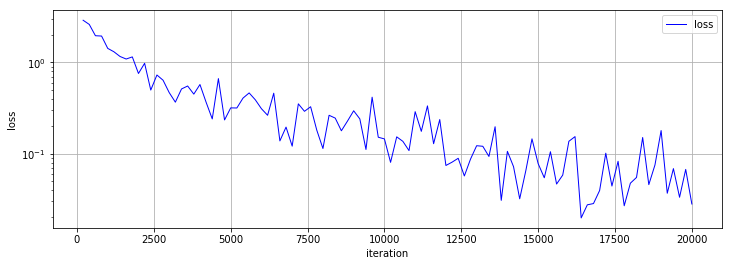

In [18]:
# 画出每一次训练的损失值线图
train_data = np.loadtxt(LOG_DIR+'/training.txt')

fig, ax = plt.subplots(figsize=(12, 4))

ax.semilogy(train_data[:, 0], train_data[:, 1], 'b-', linewidth=1.0, label='loss')

ax.grid(True)
ax.legend(loc='upper right')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')

plt.show()

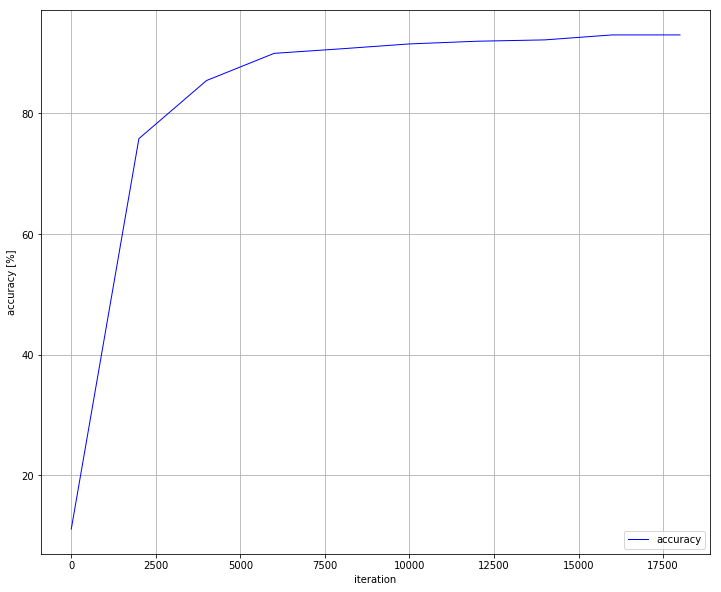

In [19]:
# 画出评估准确率线图
train_data = np.loadtxt(LOG_DIR+'/validation.txt')

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(train_data[:, 0], train_data[:, 2]*100, 'b-', linewidth=1.0, label='accuracy')

# tidy up the figure
ax.grid(True)
ax.legend(loc='lower right')
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy [%]')
#ax.set_ylim(98,100)

plt.show()

In [20]:
# 用测试数据集评估模型，打印准确率
output = estimator.evaluate(input_fn(valid_set, mode=tf.estimator.ModeKeys.EVAL))
print(output['accuracy'])

num_samples:4487
Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.
Instructions for updating:
Replace `num_threads=T` with `num_parallel_calls=T`. Replace `output_buffer_size=N` with `ds.prefetch(N)` on the returned dataset.
Instructions for updating:
Replace `num_threads=T` with `num_parallel_calls=T`. Replace `output_buffer_size=N` with `ds.prefetch(N)` on the returned dataset.
start define CNN Model
Start to define arch
[None, 100, 300, 1]
100 300
INFO:tensorflow:Starting evaluation at 2018-03-20-05:54:58
INFO:tensorflow:Restoring parameters from ./iam_output_smallsize\model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-03-20-05:55:24
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9338088, global_step = 20000, loss = 0.22012669
0.9338088


### 用模型预测识别自己的手写英文单词图片
当完成训练和评估后，我们可以部署模型用来识别模型从未见过的手写英文单词图片

In [44]:
# 以下代码识别我们的测试数据集，显示每个单词类别的识别准确率

# 注意，这一步时，模型还未执行识别操作
output = estimator.predict(input_fn(valid_set, mode=tf.estimator.ModeKeys.PREDICT),checkpoint_path=LOG_DIR+'\model.ckpt-20000')
print("predict done")
labels = get_labels(valid_set)

# We need to loop over the returned 'output' generator to actually execute the network for the current sample.
# 遍历前面创建的'output' 生成器，并真正执行识别当前样本
error_count= np.zeros(166)
total_count = np.zeros(166)
for label,out in zip(labels, output):
    #print ('Actual class / Predicted class  {} / {}'.format(label, out['prediction']))
    total_count[int(label)] += 1
    if not label == out['prediction']:
        #print ('Actual class / Predicted class  {} / {}'.format(label, out['prediction']))
        error_count[int(label)] +=1



num_samples:4487
predict done
start define CNN Model
Start to define arch
[None, 100, 300, 1]
100 300
INFO:tensorflow:Restoring parameters from ./iam_output_smallsize\model.ckpt-20000


In [43]:
# 打印单词ID，训练集数量， 测试集的准确率, 训练集数量是测试集的9倍
total = 0
for i in total_count:
    total = total + i
error = 0
for i in error_count:
    error = error + i
    
print("error count, total validate count, accuracy %")
print("%11d"%error+', '+"%20d"%total+', '+'%10.2f'%((1-error/total)*100))
print("----------------------------------------------------------------------")

print ('Word ID, num of training images, accuracy on validation set')
for i in range(len(total_count)):
    print ("%7d"%i+ ', %22d'%(total_count[i]*9)+', %25.2f'%((1-error_count[i]/total_count[i])*100)+'%')
    


error count, total validate count, accuracy %
        297,                 4487,      93.38
----------------------------------------------------------------------
Word ID, num of training images, accuracy on validation set
      0,                    135,                     80.00%
      1,                     90,                     70.00%
      2,                     81,                    100.00%
      3,                     54,                     50.00%
      4,                    135,                     86.67%
      5,                     54,                    100.00%
      6,                     63,                     85.71%
      7,                     81,                    100.00%
      8,                    243,                     62.96%
      9,                    540,                     96.67%
     10,                    135,                     60.00%
     11,                    216,                    100.00%
     12,                     54,                    100.0

In [62]:
#以4列展现待识别的手写英文单词图片一集识别的类别编号和单词
# output：      estimator.prdict output 生成器
# files：      待识别的手写英文单词图片文件全路径名列表
# index File： 单词类别编码对应单词索引csv文件
def displayPredict(files, indexFile, output):
    wordDict = {}
    with open(indexFile, newline='') as f:
        f_csv = csv.reader(f)
        headers = next(f_csv)
        for row in f_csv:
            wordDict[row[1]] = row[0]

        num_images = len(files)
        print(num_images)

        fig, axs = plt.subplots((num_images // 4+1), 4, figsize=(24,24))
        axs = axs.ravel()
        count = 0
        
       # 遍历'output' 生成器，并真正执行识别当前样本,当模型返回识别为某类单词的概率大于概率阈值时，采用模型识别结果，
       # 否则放弃模型的结果，判定该样本不在支持的可识别单词类别范围里
        for file, out in zip(files, output):
            #for file, label in zip(files, labels):   
            img=mpimg.imread(file)
            #label = file.split(os.sep)[-1].split('.')[-2].split('-')[-1]
            #axs[count].set_title('label:'+label+ '/predict:'+ str(out['prediction'])+ ' '+wordDict[str(out['prediction'])])
            if out['probabilities'] > params['threshold_probability']:
                axs[count].set_title('predict:'+ str(out['prediction'])+ ' '+wordDict[str(out['prediction'])]+ ' prob:%5.2f'%out['probabilities'])
            else:
                axs[count].set_title('predict:'+ str(166)+ ' '+wordDict[str(params['num_classes'])]+ ' prob:%5.2f'%out['probabilities'])
            print('File: ',file,' Prob: ', out['probabilities'])
        # axs[count].set_title('label:'+label)
            axs[count].imshow(img, cmap='gray')
            axs[count].set_xticks([])
            axs[count].set_yticks([])
            count = count +1

In [51]:
#归一化待识别的单词图片使图片变为和训练图片一样的尺寸100x300，背景为黑色，字为白色的黑白图片
#1.读入图片                2. 把彩色图片转背景为黑色，字为白色的黑白图片
#3.把多余的黑色背景切掉      4. 按比例无变形的缩放图片，填充图片将图片尺寸变为675x243
def normalizeImg(filename, stdRow, stdCol):
    """normalize images to make it a black&white 243x675 image like normalized training images
    Args:
        filename: full path of image file
        stdRow: number of rows of normalized image
        stdCol: number of columns of normalized image
    Returns:
        normalized image
    """
    img = cv2.imread(filename)
    grey = blackwhiteImg(img)
    grey = cropImg(grey)
    
    rows, cols = grey.shape
    rowRatio = stdRow/rows
    colRatio = stdCol/cols
    if (rows<=stdRow) and (cols<=stdCol):
        if rowRatio < colRatio:
            grey = cv2.resize(grey, None, fx=rowRatio, fy=rowRatio, interpolation=cv2.INTER_CUBIC) 
        else:
            grey = cv2.resize(grey,None,fx=colRatio,fy=colRatio, interpolation=cv2.INTER_CUBIC)
 
    elif (rows>=stdRow) and (cols>=stdCol):
        if rowRation < colRatio:
            grey = cv2.resize(grey, None, fx=rowRatio, fy=rowRatio, interpolation=cv2.INTER_LINEAR)
  
        else:
            grey = cv2.resize(grey, None, fx=colRatio, fy=colRatio, interpolation=cv2.INTER_LINEAR)
            
    elif (rows>=stdRow) and (cols<=stdCol):
        grey = cv2.resize(grey, None, fx=rowRatio, fy=rowRatio, interpolation=cv2.INTER_LINEAR)
        
    elif (rows<=stdRow) and (cols>=stdCol):
        grey = cv2.resize(grey, None, fx=colRatio, fy=colRatio, interpolation=cv2.INTER_LINEAR)
        
    rows, cols = grey.shape
    print(rows,cols)
    if stdRow>=rows:
        rowsPadding = (math.ceil((stdRow-rows)/2),math.floor((stdRow-rows)/2))
    if stdCol>=cols:
        colsPadding = (math.ceil((stdCol-cols)/2),math.floor((stdCol-cols)/2))
    grey = np.lib.pad(grey,(rowsPadding,colsPadding),'constant')
    
    
    return grey

In [52]:
def convertImg(srcPath, destPath, res):
    files = sorted(glob.glob(srcPath+'/*.png'))
    maxrow = res[0]
    maxcol = res[1]

    for filename in files:
        if os.path.getsize(filename)>0 :           
            img = normalizeImg(filename, maxrow,maxcol)
            name = filename.split(os.sep)[-1]
            cv2.imwrite(destPath+'/'+name,img)
            print(name, filename)

num_samples:39
39
start define CNN Model
Start to define arch
[None, 100, 300, 1]
100 300
INFO:tensorflow:Restoring parameters from ./iam_output_smallsize\model.ckpt-20000
File:  ./words\Line0Word0.jpg  Prob:  0.9786718
File:  ./words\Line0Word1.jpg  Prob:  0.32275003
File:  ./words\Line0Word2.jpg  Prob:  0.8274298
File:  ./words\Line10Word0.jpg  Prob:  0.7096931
File:  ./words\Line10Word1.jpg  Prob:  0.9141075
File:  ./words\Line10Word2.jpg  Prob:  0.4544508
File:  ./words\Line10Word3.jpg  Prob:  0.8718383
File:  ./words\Line1Word0.jpg  Prob:  0.9995565
File:  ./words\Line1Word1.jpg  Prob:  0.99976593
File:  ./words\Line2Word0.jpg  Prob:  0.82457924
File:  ./words\Line2Word1.jpg  Prob:  0.92460763
File:  ./words\Line2Word2.jpg  Prob:  0.520165
File:  ./words\Line2Word3.jpg  Prob:  0.26226705
File:  ./words\Line3Word0.jpg  Prob:  0.433676
File:  ./words\Line3Word1.jpg  Prob:  0.99989176
File:  ./words\Line3Word2.jpg  Prob:  0.99906963
File:  ./words\Line3Word3.jpg  Prob:  0.8274298
Fil

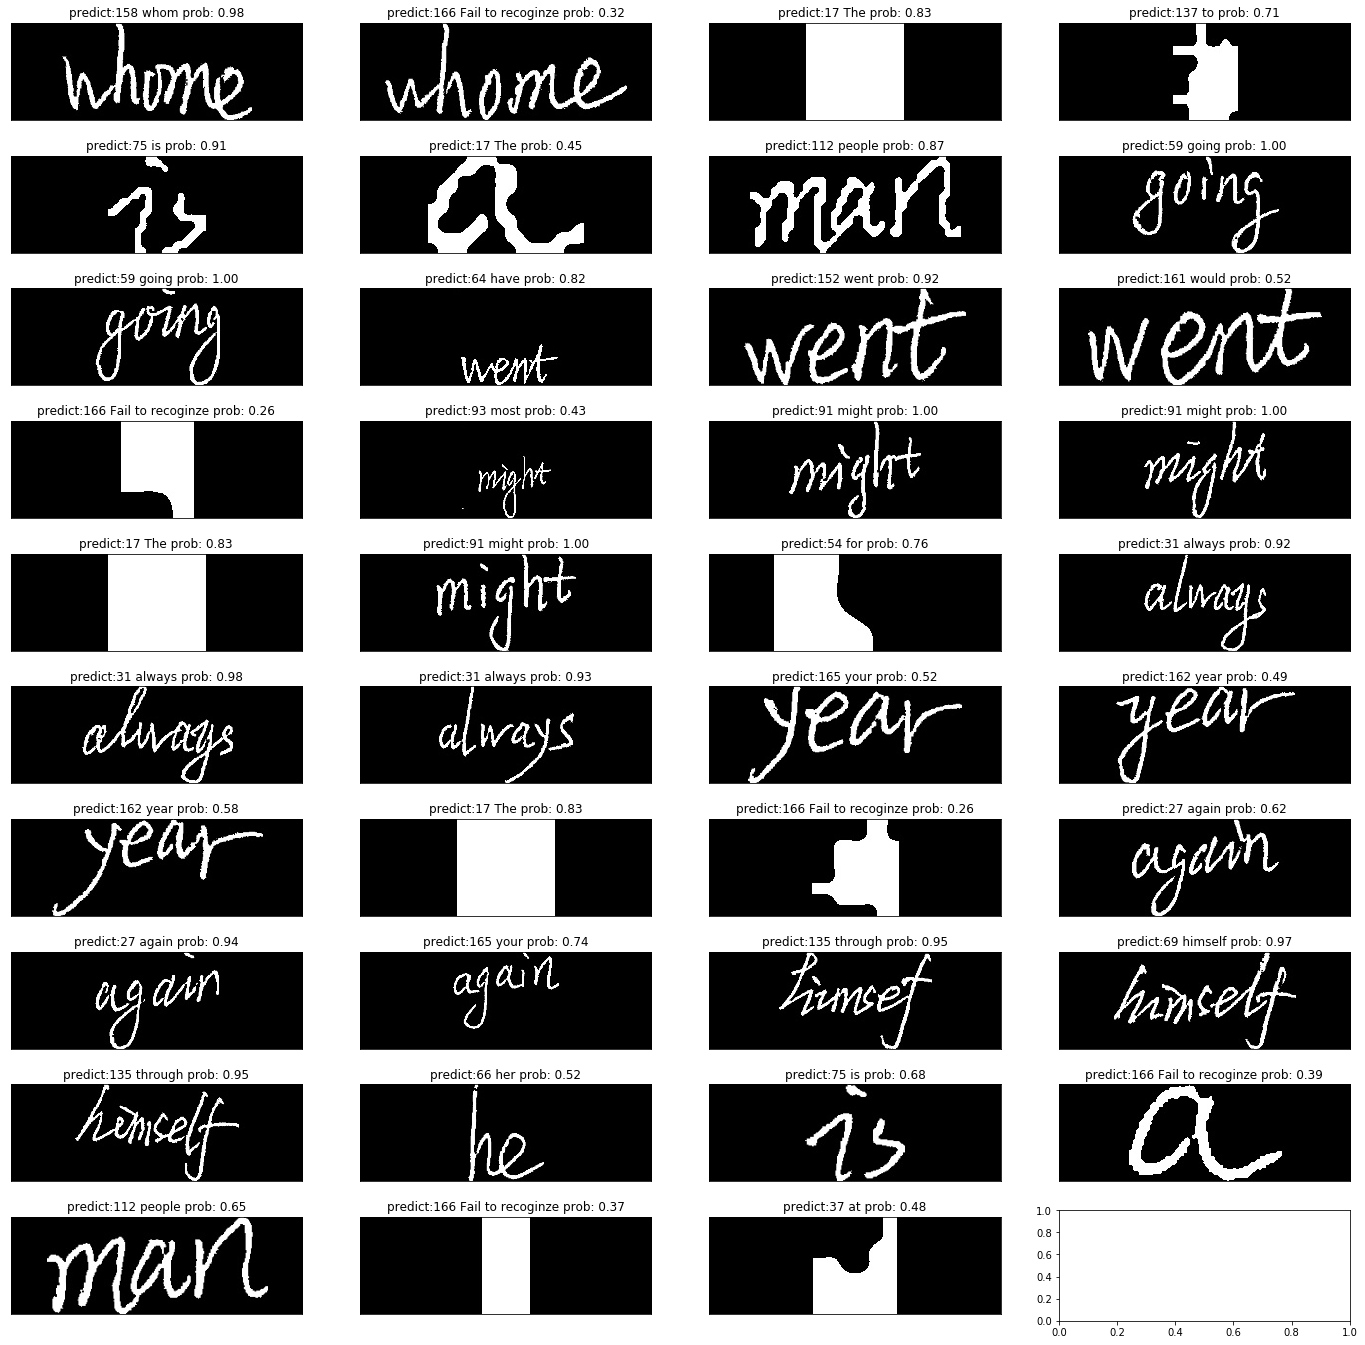

In [68]:
# 识别指定目录里所有图片文件

indexFile = WORK_DIR+'/finalWordIndex.csv'
#convertImg(DIR+'/backupWords', DIR+'/ownWords', IMAGE_RES)
own_set = get_sample_filenames(WORK_DIR+'/words',level=0)
#print(own_set)
#print(own_set[0].split(os.sep)[-1].split('.')[-2].split('-')[-1])
#选择某次已存的训练结果预测
#checkpoint_path: 指向某次训练结果文件全路径名(但不包括'.index' 和'.meta'后缀)
output = estimator.predict(input_fn(own_set, mode=tf.estimator.ModeKeys.PREDICT),checkpoint_path=LOG_DIR+'\model.ckpt-20000')
displayPredict(own_set, indexFile, output)